# Clustering

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

data = pd.read_excel("data.xlsx")
data.drop(data.filter(regex="Unname"),axis=1, inplace=True)

X = data.drop("responder", axis=1)
y = data["responder"]

manjkajoce = X.isnull().sum()
meja = 0.2
for col in X.columns:
    if manjkajoce[col] > 0:
        # Imputiramo manjkajoče vrednosti
        if manjkajoce[col] < len(X)*meja:
            if X[col].dtype == 'float64':
                X[col].fillna(X[col].mean(), inplace=True)
            else:
                X[col].fillna(X[col].mode()[0], inplace=True)
        # ali pa stolpcec zavržemo
        else:
            X.drop(col, axis=1, inplace=True)

X = pd.DataFrame(X).to_numpy()
y = pd.DataFrame(y).to_numpy()

from operator import add
from functools import reduce

y = [reduce(add, lst) for lst in y]
y = np.array(y)

## Gap statistika

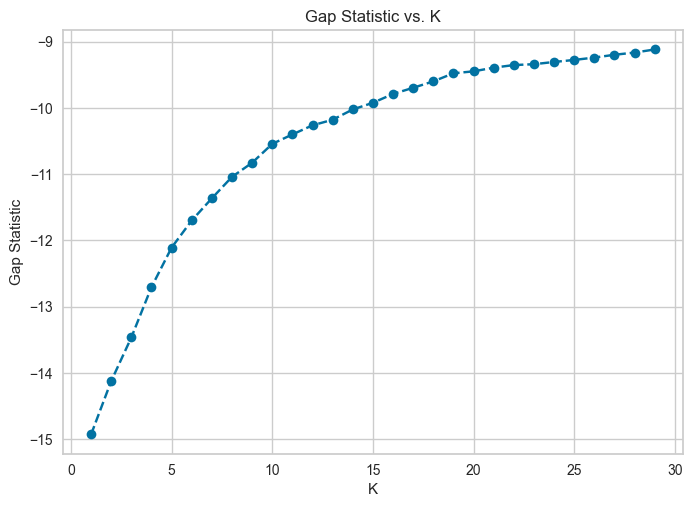

In [10]:
# Gap Statistic for K means
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
# Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
# Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
# Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)
score_g, df = optimalK(X, nrefs=5, maxClusters=30)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

## Elbow method

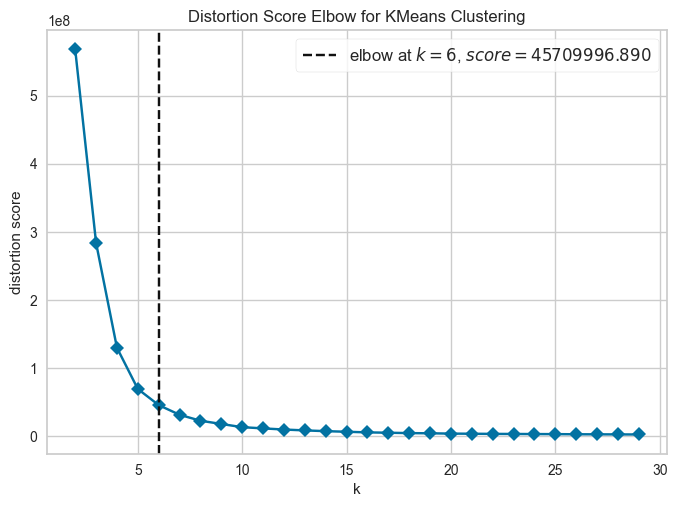

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= False)
visualizer.fit(X)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

## Silhouette Score

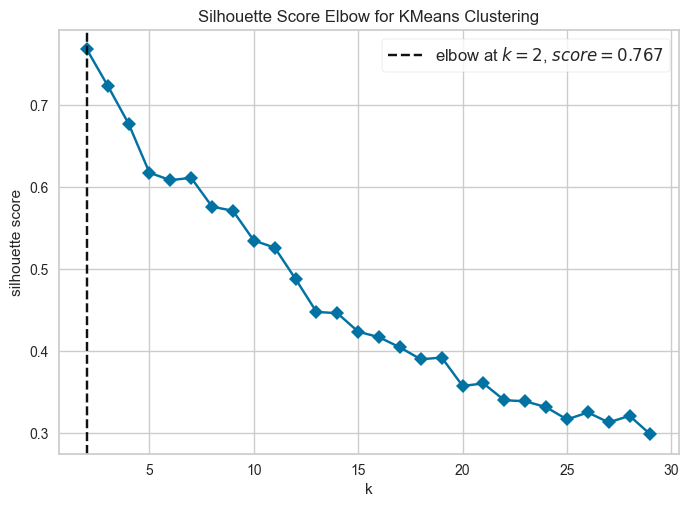

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [12]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= False)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Calinski Harabasz Score

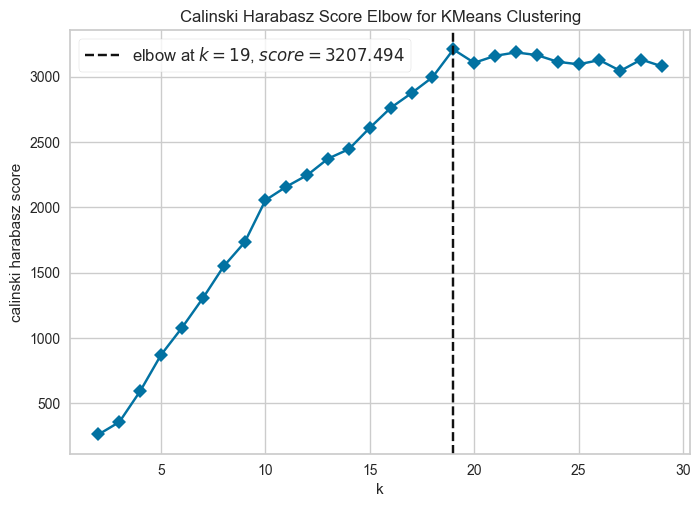

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [13]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= False)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Davies Bouldin score

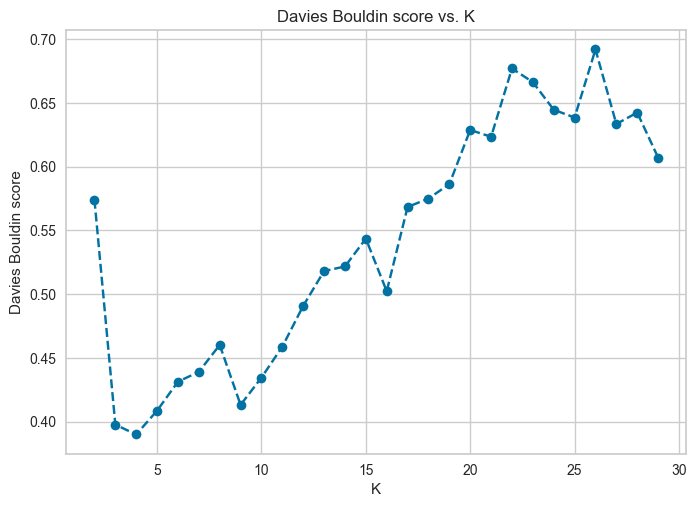

In [14]:
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)
# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(X)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(X, model)
    
    return score
scores = []
centers = list(range(2,30))
for center in centers:
    scores.append(get_kmeans_score(X, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');

#### Optimalno 4 ali 9

## Dendogram

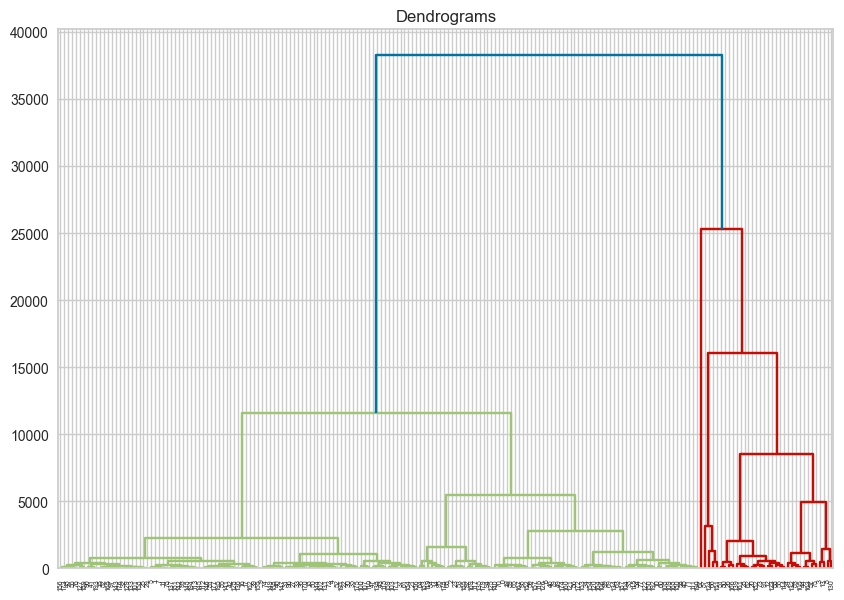

In [15]:
# Dendogram for Heirarchical Clustering
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

## Bayesian information criterion

In [16]:
from sklearn.mixture import GaussianMixture
n_components = range(1, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov)
        gmm.fit(X)
        score.append((cov,n_comp,gmm.bic(X)))
score

[('spherical', 1, 80995.38265385064),
 ('spherical', 2, 70091.95561971991),
 ('spherical', 3, 64411.65757584148),
 ('spherical', 4, 62874.2463047343),
 ('spherical', 5, 61414.66673319536),
 ('spherical', 6, 60137.93970701865),
 ('spherical', 7, 59076.43950100685),
 ('spherical', 8, 58181.13192005625),
 ('spherical', 9, 56694.83187903725),
 ('spherical', 10, 56033.246199465415),
 ('spherical', 11, 56037.11748995729),
 ('spherical', 12, 54964.17921822607),
 ('spherical', 13, 54646.90346529228),
 ('spherical', 14, 54857.10034641029),
 ('spherical', 15, 53237.12137413061),
 ('spherical', 16, 53140.014751652205),
 ('spherical', 17, 52725.34977335423),
 ('spherical', 18, 52010.226694580284),
 ('spherical', 19, 51888.78274169687),
 ('spherical', 20, 50911.436626340925),
 ('spherical', 21, 50823.25224112227),
 ('spherical', 22, 51262.30142702988),
 ('spherical', 23, 50510.41947799959),
 ('spherical', 24, 50273.77989189018),
 ('spherical', 25, 49118.889154639284),
 ('spherical', 26, 50163.87786